# **1. Instalação**

In [23]:
#%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm river

# **2. Importação das Bibliotecas Auxiliares**

In [24]:
from preprocessamento.SeriesProcessor import SeriesProcessor
from frameworkDetector.framework_detector import FrameworkDetector # Sua classe principal
from utils import Visualizer
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
from frameworkDetector.framework_detector import FrameworkDetector

from detectores.KSWINDetector import KSWINDetector
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo

# **3. Importação das Classes do Framework**

In [25]:
from preprocessamento.SeriesProcessor import SeriesProcessor
from frameworkDetector.framework_detector import FrameworkDetector
from utils import Visualizer

# **4. Importação de Detectores**

In [26]:
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

# **5. Importação de Modeos** 

In [27]:
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo


# **6. Lista de Séries Temporais**

In [28]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# **7. Definição de Parâmetros**

In [29]:
lags = 5
serie_escolhida = series[2]  # ^BVSP
print(f"Processando série: {serie_escolhida}")

# Parâmetros do framework
tamanho_janela = 100
intervalo_adicao_pool = 30
observacoes_novo_conceito = 55
detector_escolhido = "KSWIN"
tipo_modelo_inicial_global = RandomForestModelo
max_pool_size = 5
min_diversidade_erro = 0.05
n_clusters_regimes = 5
limiar_degradacao = 0.15
threshold_melhoria_alerta = 0.94
metrics_interval = 50
min_samples_for_metrics = 5
max_regimes_ciclo = 4

Processando série: ^IXIC


# **8. Obtenção e Pré-processamento dos Dados**

In [30]:
# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

# Definindo tamanho do conjunto inicial de treinamento (20% dos dados)
initial_size = int(0.2 * len(X))
#if len(X) > 0 and initial_size == 0:
    #initial_size = 1
#elif len(X) == 0:
    #initial_size = 0
    #print(f"Tamanho do conjunto inicial de treinamento: {initial_size} amostras")

# Dividindo os dados em conjunto inicial e streaming
X_init = X[:initial_size]
y_init = Y[:initial_size]
X_stream = X[initial_size:]
Y_stream = Y[initial_size:]

print(f"Shape do X_init: {X_init.shape}")
print(f"Shape do Y_init: {y_init.shape}")
print(f"Shape do X_stream: {X_stream.shape}")
print(f"Shape do Y_stream: {Y_stream.shape}")

[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1256, 1)
Shape dos dados de entrada (X): (1251, 5)
Shape dos dados de saída (Y): (1251, 1)
Shape do X_init: (250, 5)
Shape do Y_init: (250, 1)
Shape do X_stream: (1001, 5)
Shape do Y_stream: (1001, 1)


# **9. Inicialização do Framework - Modelo e Detector**

# 9.1 Inicializar Detector

In [31]:
detector_escolhido = "DDM"  # Pode ser "DDM", "ADWIN", "KSWIN", "HDDM_W"

print(f"Inicializando detector: {detector_escolhido}")
if detector_escolhido == "DDM":
    from detectores.DDMDetector import DDM
    detector = DDM()
elif detector_escolhido == "ADWIN":
    from detectores.ADWINDetector import ADWIN
    detector = ADWIN(delta=0.002)
elif detector_escolhido == "KSWIN":
    from detectores.KSWINDetector import KSWIN
    detector = KSWIN(alpha=0.05, window_size=100)
elif detector_escolhido == "HDDM_W":
    from detectores.HDDM_WDetector import HDDM_W
    detector = HDDM_W(drift_confidence=0.001, warning_confidence=0.005)
else:
    raise ValueError(f"Detector '{detector_escolhido}' não suportado ou não definido.")


Inicializando detector: DDM


# **10. Inicialização do Framework**

In [32]:
tamanho_janela = 100
intervalo_adicao_pool = 50
observacoes_novo_conceito = 50
max_pool_size = 5
tipo_modelo = "rf"  # Pode ser "rf", "sgd" ou "knn"

# Executa o framework
resultados = FrameworkDetector.executar_framework(
    X_init=X_init,
    y_init=y_init,
    X_stream=X_stream,
    y_stream=Y_stream,
    detector_externo=detector,
    tipo_modelo=tipo_modelo,
    tamanho_janela=tamanho_janela,
    intervalo_adicao_pool=intervalo_adicao_pool,
    observacoes_novo_conceito=observacoes_novo_conceito,
    max_pool_size=max_pool_size,
    max_regimes_ciclo=max_regimes_ciclo
)

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



=== Inicialização do Framework com Regimes Simplificados ===
Modelo inicial (RandomForest) treinado com 250 amostras.

=== Iniciando Processamento do Stream ===


Stream: 100%|██████████| 1001/1001 [00:12<00:00, 77.13it/s]


=== Processamento concluído em 12.98 segundos ===
Número de drifts detectados: 0
Pools finais por regime: {0: 5}


# **11. Visualização de Resultados**

# 11.1 Previsão vs Real

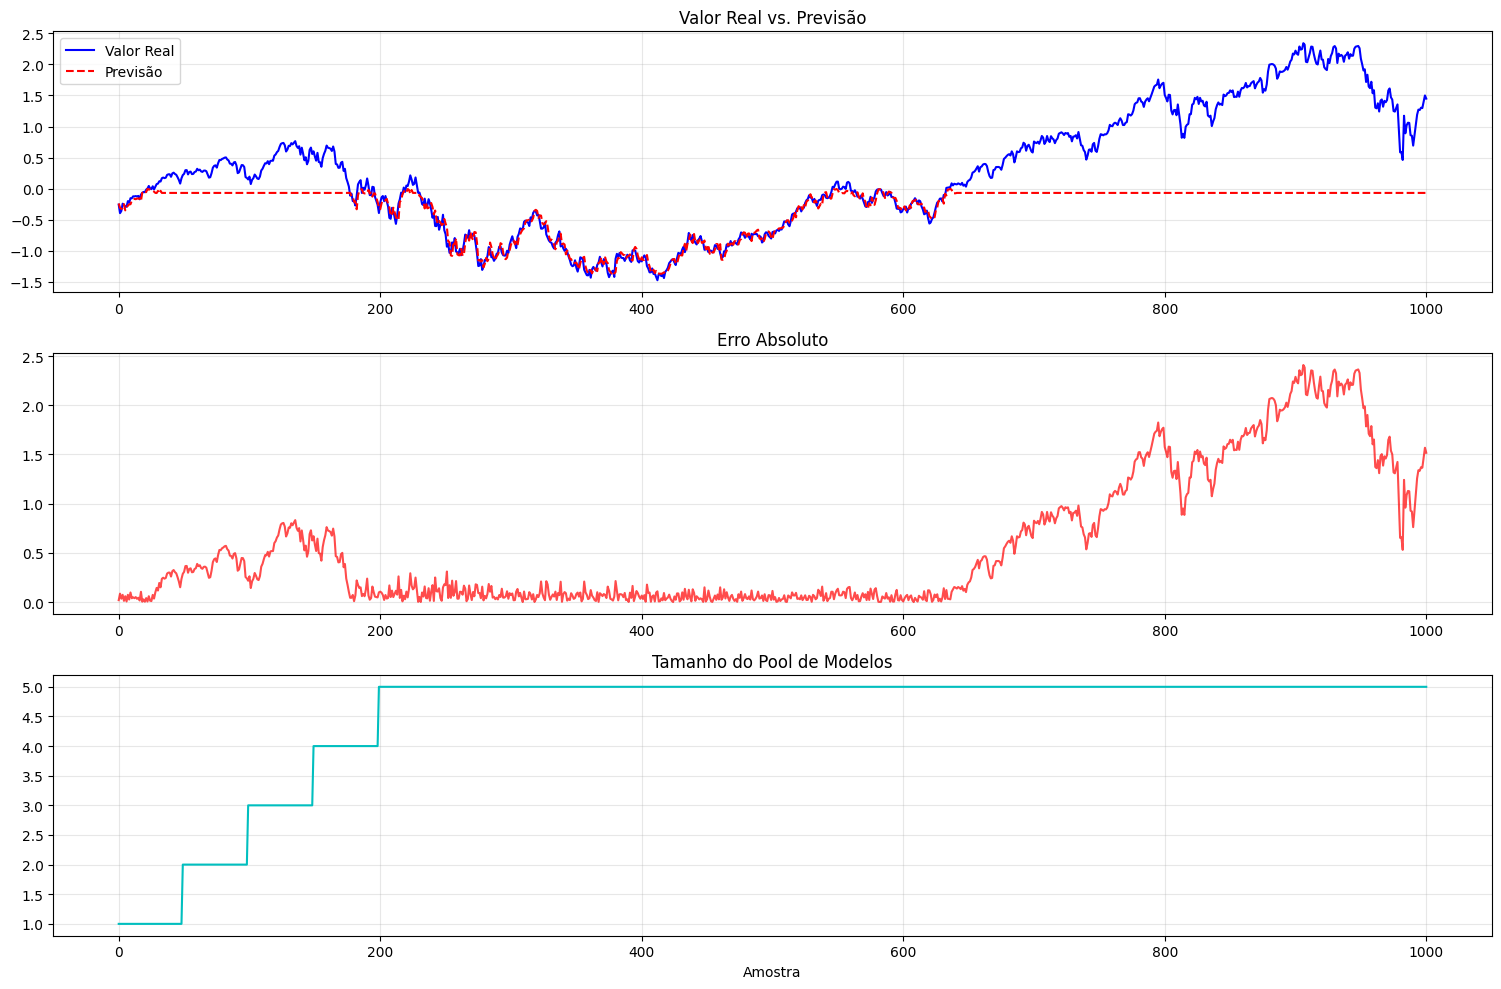

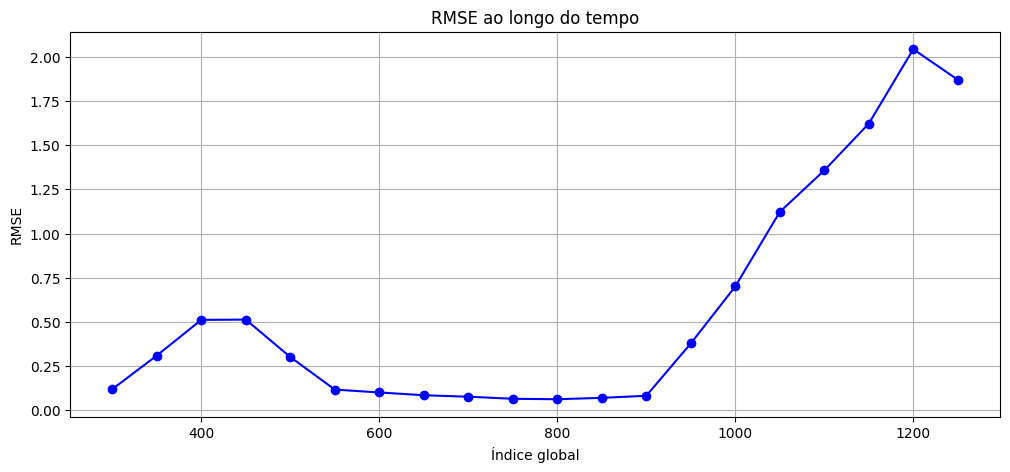

In [33]:
Visualizer.visualizar_resultados_framework(Y_stream, resultados, len(X_init))